In [ ]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor
from sklearn.multioutput import MultiOutputRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [8]:
data_train_prepared = pd.read_csv("../processed_data/data_train_prepared.csv", index_col=0, parse_dates=[0]).asfreq('h')
y_train = pd.read_csv("../processed_data/y_train.csv", index_col=0, parse_dates=[0]).asfreq('h')
data_test_prepared = pd.read_csv("../processed_data/data_test_prepared.csv", index_col=0, parse_dates=[0]).asfreq('h')
y_test = pd.read_csv("../processed_data/y_test.csv", index_col=0, parse_dates=[0]).asfreq('h')

final_test = pd.read_csv("../data/test.csv", index_col=0)

In [34]:
# Only take 10% of the dataset to model faster and already check which model works best

fraction = 0.1
data_train_prepared_sampled = data_train_prepared.sample(frac=fraction, random_state=42)
data_test_prepared_sampled = data_test_prepared.sample(frac=fraction, random_state=42)
y_train_sampled = y_train.sample(frac=fraction, random_state=42)
y_test_sampled = y_test.sample(frac=fraction, random_state=42)

In [4]:
# List of regression model descriptions for plotting

regression_descriptions = [
    'Linear Regression',
    'Ridge Regression',
    'Lasso Regression',
    'ElasticNet Regression',
    'Random Forest Regressor',
    'AdaBoost Regressor',
    'XGBoost Regressor',
    'CatBoost Regressor',
    'Bayesian Ridge',
    'Huber Regressor',
    'Passive Aggressive Regressor',
]

regressors = (
    LinearRegression(),
    Ridge(max_iter=300),
    Lasso(max_iter=300),
    ElasticNet(max_iter=300),
    RandomForestRegressor(n_estimators=300),
    MultiOutputRegressor(AdaBoostRegressor(n_estimators=300)),
    MultiOutputRegressor(XGBRegressor(n_estimators=300)),
    MultiOutputRegressor(CatBoostRegressor(silent=True)),
    MultiOutputRegressor(BayesianRidge(max_iter=300)),
    MultiOutputRegressor(HuberRegressor(max_iter=2000)),
    MultiOutputRegressor(PassiveAggressiveRegressor(max_iter=300)),
)

### Running with classical cross-validation

In [5]:
# Variables
rand_seed = 42
sample_size = 10000
repetitions = 5

cv_folds = 3
scoring_func = make_scorer(mean_absolute_error)
scoring_func_name = "MAE"

In [6]:
classifier_data = pd.DataFrame([
    {'Regressor': None,
     'Sample size': None,
     'CV folds': None,
     'Raw scores': None,
     'Mean {} score'.format(scoring_func_name): None,
     '{} score SD'.format(scoring_func_name): None,
     'Run time (min.)': None}
] * len(regression_descriptions))    # Create 15 empty rows to use for regressor metrics


ind = 0 # Initialize index to append scores to the dataframe

# Loop over regressors
for regressor, description in zip(regressors, regression_descriptions):
    
    dTs = []
    max_mems = []
    raw_scores = []
    
    for i in range(repetitions):
        
        
        start = time()

        # Cross validate regressor, tracking memory usage
        cross_val_scores = cross_val_score(
            estimator=regressor, 
            X=data_train_prepared_sampled,
            y=y_train_sampled, 
            cv=cv_folds, 
            scoring=scoring_func,
        )

        dT = np.round(((time() - start)/60), 2)
        dTs.append(dT)
        raw_scores = np.concatenate((raw_scores, cross_val_scores))
    

    mean_score = np.round(np.mean(raw_scores), 3)
    sd_score = np.round(np.std(raw_scores), 4)

    
    # Store run results in dataframe

    classifier_data.iloc[ind] = pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        dT
    ], index=classifier_data.columns)
    
    ind += 1
    
    print(f'Finished {description}, mean score: {mean_score}')

# Sort results by score
classifier_data = classifier_data.sort_values(['Mean {} score'.format(scoring_func_name)], ascending=True)

Finished Linear Regression, mean score: 2.202
Finished Ridge Regression, mean score: 2.213
Finished Lasso Regression, mean score: 5.991
Finished ElasticNet Regression, mean score: 7.985
Finished Random Forest Regressor, mean score: 2.314
Finished AdaBoost Regressor, mean score: 5.638
Finished XGBoost Regressor, mean score: 2.158
Finished CatBoost Regressor, mean score: 2.002
Finished Bayesian Ridge, mean score: 2.202
Finished Huber Regressor, mean score: 2.169
Finished Passive Aggressive Regressor, mean score: 3.47
Finished Theil-Sen Regressor, mean score: 2.222


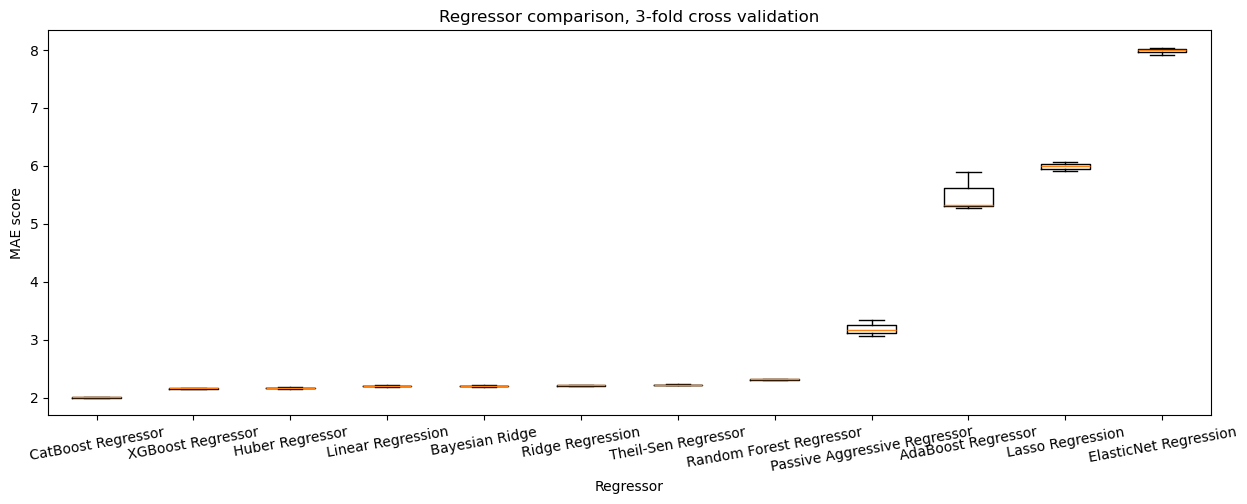

In [ ]:
# Plot comparison of regressors using mean score
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data['Raw scores'])
ax.set_xticklabels(classifier_data['Regressor'])
plt.xlabel('Regressor')
plt.ylabel('{} score'.format(scoring_func_name))
plt.title('Regressor comparison, 3-fold cross validation')
plt.xticks(rotation=10)

plt.savefig("assets/graphs/all_models_performance.png", dpi=200)

plt.show()

In [8]:
classifier_data.drop('Raw scores', axis=1)

,Regressor,Sample size,CV folds,Mean MAE score,MAE score SD,Run time (min.)
7,CatBoost Regressor,10000,3,2.002,0.0028,1.91
6,XGBoost Regressor,10000,3,2.158,0.007,0.25
9,Huber Regressor,10000,3,2.169,0.0083,2.82
0,Linear Regression,10000,3,2.202,0.0088,0.0
8,Bayesian Ridge,10000,3,2.202,0.0088,0.01
1,Ridge Regression,10000,3,2.213,0.0069,0.0
11,Theil-Sen Regressor,10000,3,2.222,0.0083,6.01
4,Random Forest Regressor,10000,3,2.314,0.005,11.18
10,Passive Aggressive Regressor,10000,3,3.47,0.4544,0.03
5,AdaBoost Regressor,10000,3,5.638,0.1919,3.62


CatBoost seems to be the best model for our use case, when using classical cross-validation

### Running with TimeSeriesSplit cross-validation

In [12]:
# Variables
rand_seed = 42
sample_size = 10000
repetitions = 5

cv_folds = TimeSeriesSplit(n_splits=5)
scoring_func = make_scorer(mean_absolute_error)
scoring_func_name = "MAE"

In [13]:
classifier_data2 = pd.DataFrame([
    {'Regressor': None,
     'Sample size': None,
     'CV folds': None,
     'Raw scores': None,
     'Mean {} score'.format(scoring_func_name): None,
     '{} score SD'.format(scoring_func_name): None,
     'Run time (min.)': None}
] * len(regression_descriptions))    # Create 15 empty rows to use for regressor metrics


ind = 0 # Initialize index to append scores to the dataframe

# Loop over regressors
for regressor, description in zip(regressors, regression_descriptions):
    
    dTs = []
    max_mems = []
    raw_scores = []
    
    for i in range(repetitions):
        
        
        start = time()

        # Cross validate regressor, tracking memory usage
        cross_val_scores = cross_val_score(
            estimator=regressor, 
            X=data_train_prepared_sampled,
            y=y_train_sampled, 
            cv=cv_folds, 
            scoring=scoring_func,
        )

        dT = np.round(((time() - start)/60), 2)
        dTs.append(dT)
        raw_scores = np.concatenate((raw_scores, cross_val_scores))
    

    mean_score = np.round(np.mean(raw_scores), 3)
    sd_score = np.round(np.std(raw_scores), 4)

    
    # Store run results in dataframe

    classifier_data2.iloc[ind] = pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        dT
    ], index=classifier_data2.columns)
    
    ind += 1
    
    print(f'Finished {description}, mean score: {mean_score}')

# Sort results by score
classifier_data2 = classifier_data2.sort_values(['Mean {} score'.format(scoring_func_name)], ascending=True)

Finished Linear Regression, mean score: 1130507739.167
Finished Ridge Regression, mean score: 2.526
Finished Lasso Regression, mean score: 5.975
Finished ElasticNet Regression, mean score: 7.947
Finished Random Forest Regressor, mean score: 2.772
Finished AdaBoost Regressor, mean score: 3.514
Finished XGBoost Regressor, mean score: 2.471
Finished CatBoost Regressor, mean score: 2.282
Finished Bayesian Ridge, mean score: 2.273
Finished Huber Regressor, mean score: 2.197
Finished Passive Aggressive Regressor, mean score: 3.424
Finished Theil-Sen Regressor, mean score: 2.284


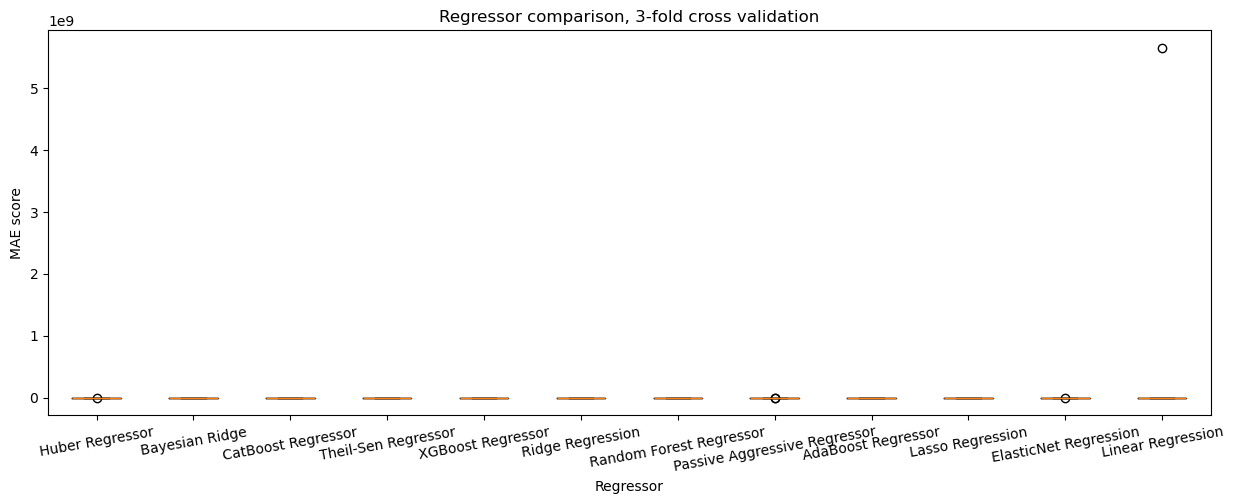

In [ ]:
# Plot comparison of regressors using mean score
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data2['Raw scores'])
ax.set_xticklabels(classifier_data2['Regressor'])
plt.xlabel('Regressor')
plt.ylabel('{} score'.format(scoring_func_name))
plt.title('Regressor comparison, 3-fold cross validation')
plt.xticks(rotation=10)

plt.savefig("assets/graphs/all_models_performance2.png", dpi=200)

plt.show()

In [15]:
classifier_data2.drop('Raw scores', axis=1)

,Regressor,Sample size,CV folds,Mean MAE score,MAE score SD,Run time (min.)
9,Huber Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.197,0.0947,0.19
8,Bayesian Ridge,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.273,0.1236,0.01
7,CatBoost Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.282,0.1535,1.55
11,Theil-Sen Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.284,0.1216,7.03
6,XGBoost Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.471,0.1121,0.26
1,Ridge Regression,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.526,0.2332,0.0
4,Random Forest Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.772,0.1735,0.62
10,Passive Aggressive Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",3.424,0.3851,0.0
5,AdaBoost Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",3.514,0.1783,0.49
2,Lasso Regression,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",5.975,0.1112,0.0


# Predictions

## With basic CatBoost

In [16]:
catboost = MultiOutputRegressor(CatBoostRegressor(silent=True))

catboost.fit(data_train_prepared, y_train)

prediction_cat = catboost.predict(data_test_prepared)
prediction_cat[prediction_cat < 0] = 0
rmse_test_cat = mean_absolute_error(prediction_cat, y_test)**0.5
rmse_train_cat = mean_absolute_error(catboost.predict(data_train_prepared), y_train)**0.5

print(f'The train mae is {rmse_train_cat} and the test mae is {rmse_test_cat}.')

The train rmse is 1.297260121355796 and the test rmse is 1.3944469983594345.


In [24]:
path_test = "../data/test.csv"
test = pd.read_csv(path_test)
test["id"] = pd.to_datetime(test["id"])

final_pred_cat = catboost.predict(test)
final_pred_cat[final_pred_cat < 0] = 0

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name cat__year_2020 (found id).

In [19]:
final_pred_cat.to_csv("../output/predictions_cat.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'write_csv'

## With basic Huber

In [17]:
huber = MultiOutputRegressor(HuberRegressor(max_iter=2000))

huber.fit(data_train_prepared, y_train)

prediction_huber = huber.predict(data_test_prepared)
prediction_huber[prediction_huber < 0] = 0
rmse_test_huber = mean_absolute_error(prediction_huber, y_test)**0.5
rmse_train_huber = mean_absolute_error(huber.predict(data_train_prepared), y_train)**0.5

print(f'The train mae is {rmse_train_huber} and the test mae is {rmse_test_huber}.')

The train mae is 1.471099673752445 and the test mae is 1.460540525434569.


In [ ]:
prediction_huber.to_csv("../output/predictions_huber.csv")

## With skforecast

In [26]:
forecasters = {}
for col in y_train.columns:
    forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=123),
        lags      = 6)
    forecaster.fit(y=y_train[col], exog=data_train_prepared)
    forecasters[col] = forecaster

In [27]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['cat__year_2020', 'cat__year_2021', 'cat__year_2022', 'cat__year_2023', 'cat__year_2024', 'cat__holiday_0', 'cat__holiday_1', 'cat__rush_hour_0', 'cat__rush_hour_1', 'cat__lockdown_0', 'cat__lockdown_1', 'cat__curfew_0', 'cat__curfew_1', 'num__weekend', 'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1', 'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1', 'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2', 'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2', 'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3', 'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3', 'num__flow', 'num__occupation_rate', 'num__ALTI', 'num__RR1', 'num__QRR1', 'num__T', 'num__QT', 'num__TN', 'n

In [37]:
steps = 2520
predictions = forecaster.predict(steps=steps, exog=data_test_prepared)

In [45]:
final_pred_cat = pd.DataFrame(np.array(predictions).reshape(504, 5), columns=['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'])
final_pred_cat.index = final_test.index
final_pred_cat

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
id,,,,,
2024-09-03 23,5.467498,5.603025,5.824479,6.075848,6.219339
2024-09-04 00,6.369899,7.124723,8.232538,9.571714,10.065667
2024-09-04 01,9.523861,8.811871,7.990769,7.289413,6.765058
2024-09-04 02,6.118032,6.197222,6.061545,5.666000,6.448000
2024-09-04 03,7.530210,7.503000,7.586769,7.846000,7.886000
...,...,...,...,...,...
2024-09-24 18,6.976000,6.964636,6.586182,5.833182,5.490000
2024-09-24 19,5.590500,5.961091,5.826000,5.799727,5.606000
2024-09-24 20,5.740364,5.630750,5.390333,5.351333,5.309333


In [46]:
final_pred_cat.to_csv("../output/submission.csv")

In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def calculate_average_mae(predictions, actuals, target_columns):
    """
    Calculate the MAE for each pollutant and return the average MAE.

    Parameters:
    - predictions: dict of lists where keys are target columns and values are lists of predicted values
    - actuals: DataFrame containing the actual values of the pollutants
    - target_columns: List of target column names corresponding to pollutants
    
    Returns:
    - average_mae: float, average MAE across the pollutants
    """
    mae_values = []
    
    for target in target_columns:
        # Calculate MAE for each pollutant
        mae = mean_absolute_error(actuals[target], predictions[target])
        mae_values.append(mae)
        print(F"mae for {target} is {mae}")
    
    # Calculate the average MAE
    average_mae = np.mean(mae_values)
    return average_mae

# Example usage
target_columns = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]
average_mae = calculate_average_mae(y_pred_df, y_test, target_columns)
print("Average MAE:", average_mae)


mae for valeur_NO2 is 2.637602320965481
mae for valeur_CO is 0.015775625894466294
mae for valeur_O3 is 4.356802746237024
mae for valeur_PM10 is 1.547364741296654
mae for valeur_PM25 is 1.063791249252294
Average MAE: 1.924267336729184
